In [12]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D
import os
from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [3]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

s = 82 # output slice size
ts = 82 # input slice size 32

In [4]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape

(4000, 82)

In [5]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [6]:
c=c[:]
r=r[:]

In [7]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')





train_size: 3200 profiles
test_size: 800 profiles


In [10]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [17]:
checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 2000

    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1)))(input_layer) 
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi) 
    flat=tf.keras.layers.Flatten()(bi)
    output = tf.keras.layers.Dense(82,activation='relu')(flat)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
     # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [23]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds) #800

X_train=np.zeros((5,800*4,ts))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [24]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 1)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 82, 128)           33792     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 82, 128)           98816     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 82)                860754    
Total params: 993,362
Trainable params: 993,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
150/150 [==============================] - 11s 30ms/step - loss: 111.1377 - mean_squared_error: 111.1377 - r

150/150 [==============================] - 3s 18ms/step - loss: 0.4794 - mean_squared_error: 0.4794 - root_mean_squared_error: 0.6923 - val_loss: 0.5785 - val_mean_squared_error: 0.5785 - val_root_mean_squared_error: 0.7606

Epoch 00026: saving model to training_4\cp.ckpt
Epoch 27/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.4806 - mean_squared_error: 0.4806 - root_mean_squared_error: 0.6932 - val_loss: 0.5978 - val_mean_squared_error: 0.5978 - val_root_mean_squared_error: 0.7732

Epoch 00027: saving model to training_4\cp.ckpt
Epoch 28/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.4718 - mean_squared_error: 0.4718 - root_mean_squared_error: 0.6868 - val_loss: 0.5830 - val_mean_squared_error: 0.5830 - val_root_mean_squared_error: 0.7636

Epoch 00028: saving model to training_4\cp.ckpt
Epoch 29/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.4656 - mean_squared_error: 0.4656 - root_mean_squared_error: 0.6823 - val


Epoch 00054: saving model to training_4\cp.ckpt
Epoch 55/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3003 - mean_squared_error: 0.3003 - root_mean_squared_error: 0.5480 - val_loss: 0.5176 - val_mean_squared_error: 0.5176 - val_root_mean_squared_error: 0.7195

Epoch 00055: saving model to training_4\cp.ckpt
Epoch 56/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3123 - mean_squared_error: 0.3123 - root_mean_squared_error: 0.5588 - val_loss: 0.5094 - val_mean_squared_error: 0.5094 - val_root_mean_squared_error: 0.7137

Epoch 00056: saving model to training_4\cp.ckpt
Epoch 57/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3007 - mean_squared_error: 0.3007 - root_mean_squared_error: 0.5484 - val_loss: 0.4881 - val_mean_squared_error: 0.4881 - val_root_mean_squared_error: 0.6987

Epoch 00057: saving model to training_4\cp.ckpt
Epoch 58/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2950 - mea

150/150 [==============================] - 3s 18ms/step - loss: 4.9463 - mean_squared_error: 4.9463 - root_mean_squared_error: 2.2239 - val_loss: 4.6559 - val_mean_squared_error: 4.6559 - val_root_mean_squared_error: 2.1578

Epoch 00007: saving model to training_4\cp.ckpt
Epoch 8/2000
150/150 [==============================] - 3s 18ms/step - loss: 4.2561 - mean_squared_error: 4.2561 - root_mean_squared_error: 2.0629 - val_loss: 3.9894 - val_mean_squared_error: 3.9894 - val_root_mean_squared_error: 1.9973

Epoch 00008: saving model to training_4\cp.ckpt
Epoch 9/2000
150/150 [==============================] - 3s 18ms/step - loss: 3.5744 - mean_squared_error: 3.5744 - root_mean_squared_error: 1.8906 - val_loss: 3.4773 - val_mean_squared_error: 3.4773 - val_root_mean_squared_error: 1.8647

Epoch 00009: saving model to training_4\cp.ckpt
Epoch 10/2000
150/150 [==============================] - 3s 18ms/step - loss: 3.0363 - mean_squared_error: 3.0363 - root_mean_squared_error: 1.7424 - val_l


Epoch 00035: saving model to training_4\cp.ckpt
Epoch 36/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.4195 - mean_squared_error: 0.4195 - root_mean_squared_error: 0.6477 - val_loss: 0.5345 - val_mean_squared_error: 0.5345 - val_root_mean_squared_error: 0.7311

Epoch 00036: saving model to training_4\cp.ckpt
Epoch 37/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.4100 - mean_squared_error: 0.4100 - root_mean_squared_error: 0.6402 - val_loss: 0.4929 - val_mean_squared_error: 0.4929 - val_root_mean_squared_error: 0.7021

Epoch 00037: saving model to training_4\cp.ckpt
Epoch 38/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3940 - mean_squared_error: 0.3940 - root_mean_squared_error: 0.6276 - val_loss: 0.5337 - val_mean_squared_error: 0.5337 - val_root_mean_squared_error: 0.7305

Epoch 00038: saving model to training_4\cp.ckpt
Epoch 39/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.3909 - mea

150/150 [==============================] - 3s 18ms/step - loss: 0.1819 - mean_squared_error: 0.1819 - root_mean_squared_error: 0.4265 - val_loss: 0.4399 - val_mean_squared_error: 0.4399 - val_root_mean_squared_error: 0.6633

Epoch 00092: saving model to training_4\cp.ckpt
Epoch 93/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1847 - mean_squared_error: 0.1847 - root_mean_squared_error: 0.4298 - val_loss: 0.4303 - val_mean_squared_error: 0.4303 - val_root_mean_squared_error: 0.6560

Epoch 00093: saving model to training_4\cp.ckpt
Epoch 94/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1715 - mean_squared_error: 0.1715 - root_mean_squared_error: 0.4141 - val_loss: 0.4331 - val_mean_squared_error: 0.4331 - val_root_mean_squared_error: 0.6581

Epoch 00094: saving model to training_4\cp.ckpt
Epoch 95/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1721 - mean_squared_error: 0.1721 - root_mean_squared_error: 0.4148 - val


Epoch 00006: saving model to training_4\cp.ckpt
Epoch 7/2000
150/150 [==============================] - 3s 18ms/step - loss: 4.3723 - mean_squared_error: 4.3723 - root_mean_squared_error: 2.0910 - val_loss: 4.1315 - val_mean_squared_error: 4.1315 - val_root_mean_squared_error: 2.0326

Epoch 00007: saving model to training_4\cp.ckpt
Epoch 8/2000
150/150 [==============================] - 3s 18ms/step - loss: 3.6566 - mean_squared_error: 3.6566 - root_mean_squared_error: 1.9122 - val_loss: 3.5052 - val_mean_squared_error: 3.5052 - val_root_mean_squared_error: 1.8722

Epoch 00008: saving model to training_4\cp.ckpt
Epoch 9/2000
150/150 [==============================] - 3s 18ms/step - loss: 3.1356 - mean_squared_error: 3.1356 - root_mean_squared_error: 1.7707 - val_loss: 2.8885 - val_mean_squared_error: 2.8885 - val_root_mean_squared_error: 1.6996

Epoch 00009: saving model to training_4\cp.ckpt
Epoch 10/2000
150/150 [==============================] - 3s 18ms/step - loss: 2.6221 - mean_s


Epoch 00063: saving model to training_4\cp.ckpt
Epoch 64/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2538 - mean_squared_error: 0.2538 - root_mean_squared_error: 0.5037 - val_loss: 0.4423 - val_mean_squared_error: 0.4423 - val_root_mean_squared_error: 0.6650

Epoch 00064: saving model to training_4\cp.ckpt
Epoch 65/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2316 - mean_squared_error: 0.2316 - root_mean_squared_error: 0.4811 - val_loss: 0.4667 - val_mean_squared_error: 0.4667 - val_root_mean_squared_error: 0.6832

Epoch 00065: saving model to training_4\cp.ckpt
Epoch 66/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2380 - mean_squared_error: 0.2380 - root_mean_squared_error: 0.4879 - val_loss: 0.4510 - val_mean_squared_error: 0.4510 - val_root_mean_squared_error: 0.6716

Epoch 00066: saving model to training_4\cp.ckpt
Epoch 67/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2390 - mea

150/150 [==============================] - 3s 18ms/step - loss: 0.6010 - mean_squared_error: 0.6010 - root_mean_squared_error: 0.7751 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - val_root_mean_squared_error: 0.8077

Epoch 00022: saving model to training_4\cp.ckpt
Epoch 23/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.5691 - mean_squared_error: 0.5691 - root_mean_squared_error: 0.7544 - val_loss: 0.6701 - val_mean_squared_error: 0.6701 - val_root_mean_squared_error: 0.8186

Epoch 00023: saving model to training_4\cp.ckpt
Epoch 24/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.5517 - mean_squared_error: 0.5517 - root_mean_squared_error: 0.7428 - val_loss: 0.5901 - val_mean_squared_error: 0.5901 - val_root_mean_squared_error: 0.7682

Epoch 00024: saving model to training_4\cp.ckpt
Epoch 25/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.5211 - mean_squared_error: 0.5211 - root_mean_squared_error: 0.7219 - val


Epoch 00050: saving model to training_4\cp.ckpt
Epoch 51/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.3185 - mean_squared_error: 0.3185 - root_mean_squared_error: 0.5643 - val_loss: 0.4648 - val_mean_squared_error: 0.4648 - val_root_mean_squared_error: 0.6817

Epoch 00051: saving model to training_4\cp.ckpt
Epoch 52/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3094 - mean_squared_error: 0.3094 - root_mean_squared_error: 0.5562 - val_loss: 0.4579 - val_mean_squared_error: 0.4579 - val_root_mean_squared_error: 0.6767

Epoch 00052: saving model to training_4\cp.ckpt
Epoch 53/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2919 - mean_squared_error: 0.2919 - root_mean_squared_error: 0.5402 - val_loss: 0.4533 - val_mean_squared_error: 0.4533 - val_root_mean_squared_error: 0.6733

Epoch 00053: saving model to training_4\cp.ckpt
Epoch 54/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.2906 - mea


Epoch 00107: saving model to training_4\cp.ckpt
Epoch 108/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - root_mean_squared_error: 0.3476 - val_loss: 0.4504 - val_mean_squared_error: 0.4504 - val_root_mean_squared_error: 0.6711

Epoch 00108: saving model to training_4\cp.ckpt
Epoch 109/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1226 - mean_squared_error: 0.1226 - root_mean_squared_error: 0.3501 - val_loss: 0.4653 - val_mean_squared_error: 0.4653 - val_root_mean_squared_error: 0.6822

Epoch 00109: saving model to training_4\cp.ckpt
Epoch 110/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1229 - mean_squared_error: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.4610 - val_mean_squared_error: 0.4610 - val_root_mean_squared_error: 0.6790

Epoch 00110: saving model to training_4\cp.ckpt
Epoch 111/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1165 -


Epoch 00039: saving model to training_4\cp.ckpt
Epoch 40/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3797 - mean_squared_error: 0.3797 - root_mean_squared_error: 0.6161 - val_loss: 0.4812 - val_mean_squared_error: 0.4812 - val_root_mean_squared_error: 0.6937

Epoch 00040: saving model to training_4\cp.ckpt
Epoch 41/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3604 - mean_squared_error: 0.3604 - root_mean_squared_error: 0.6003 - val_loss: 0.4951 - val_mean_squared_error: 0.4951 - val_root_mean_squared_error: 0.7036

Epoch 00041: saving model to training_4\cp.ckpt
Epoch 42/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3556 - mean_squared_error: 0.3556 - root_mean_squared_error: 0.5963 - val_loss: 0.4612 - val_mean_squared_error: 0.4612 - val_root_mean_squared_error: 0.6791

Epoch 00042: saving model to training_4\cp.ckpt
Epoch 43/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.3487 - mea

150/150 [==============================] - 3s 18ms/step - loss: 0.1511 - mean_squared_error: 0.1511 - root_mean_squared_error: 0.3887 - val_loss: 0.4433 - val_mean_squared_error: 0.4433 - val_root_mean_squared_error: 0.6658

Epoch 00096: saving model to training_4\cp.ckpt
Epoch 97/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - root_mean_squared_error: 0.3818 - val_loss: 0.4479 - val_mean_squared_error: 0.4479 - val_root_mean_squared_error: 0.6692

Epoch 00097: saving model to training_4\cp.ckpt
Epoch 98/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - root_mean_squared_error: 0.3885 - val_loss: 0.4410 - val_mean_squared_error: 0.4410 - val_root_mean_squared_error: 0.6640

Epoch 00098: saving model to training_4\cp.ckpt
Epoch 99/2000
150/150 [==============================] - 3s 18ms/step - loss: 0.1409 - mean_squared_error: 0.1409 - root_mean_squared_error: 0.3753 - val

In [25]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.4359 with standard devisation (0.0134)
 Test RMSE 0.6602 with standard devisation (0.0102)


In [26]:
predictions.shape

(800, 82)

In [27]:
cv_scores #MSE

[0.45138949155807495,
 0.4305380880832672,
 0.4409905672073364,
 0.41278308629989624,
 0.44388607144355774]

In [28]:
cv_scores2 #RMSE

[0.6718552112579346,
 0.6561540365219116,
 0.6640713214874268,
 0.6424819231033325,
 0.6662477850914001]

In [35]:
r_test=np.load('r_500m_sza60vza60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.
test_m=r_test[3200:]
test_l=cot[3200:]

result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 108.1300 - mean_squared_error: 108.1300 - root_mean_squared_error: 10.3986
MSE： 108.13002014160156
RMSE： 10.398558616638184


In [36]:
r_test=np.load('r_500m_sza60vza60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.
test_m=r_test[:3200]
test_l=cot[:3200]

result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 108.7506 - mean_squared_error: 108.7506 - root_mean_squared_error: 10.4284
MSE： 108.75057983398438
RMSE： 10.428354263305664


In [37]:
r_test=np.load('r_500m_sza60vza60.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 108.6264 - mean_squared_error: 108.6264 - root_mean_squared_error: 10.4224
MSE： 108.62642669677734
RMSE： 10.422402381896973


In [38]:
r_test=np.load('r_500m_sza60vza53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 96.0052 - mean_squared_error: 96.0052 - root_mean_squared_error: 9.7982
MSE： 96.00517272949219
RMSE： 9.798222541809082


In [39]:
r_test=np.load('r_500m_sza60vza53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 96.2880 - mean_squared_error: 96.2880 - root_mean_squared_error: 9.8126
MSE： 96.28804016113281
RMSE： 9.81264591217041


In [40]:
r_test=np.load('r_500m_sza60vza53.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 96.2315 - mean_squared_error: 96.2315 - root_mean_squared_error: 9.8098
MSE： 96.2314682006836
RMSE： 9.80976390838623


In [41]:
r_test=np.load('r_500m_sza60vza45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 71.2235 - mean_squared_error: 71.2235 - root_mean_squared_error: 8.4394
MSE： 71.2235336303711
RMSE： 8.43940258026123


In [42]:
r_test=np.load('r_500m_sza60vza45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 71.2207 - mean_squared_error: 71.2207 - root_mean_squared_error: 8.4392
MSE： 71.22065734863281
RMSE： 8.439234733581543


In [43]:
r_test=np.load('r_500m_sza60vza45.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 71.2212 - mean_squared_error: 71.2212 - root_mean_squared_error: 8.4393
MSE： 71.22122955322266
RMSE： 8.4392671585083


In [44]:
r_test=np.load('r_500m_sza60vza36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 33.5636 - mean_squared_error: 33.5636 - root_mean_squared_error: 5.7934
MSE： 33.563594818115234
RMSE： 5.793409824371338


In [45]:
r_test=np.load('r_500m_sza60vza36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 8ms/step - loss: 33.6643 - mean_squared_error: 33.6643 - root_mean_squared_error: 5.8021
MSE： 33.664276123046875
RMSE： 5.8020920753479


In [46]:
r_test=np.load('r_500m_sza60vza36.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 33.6441 - mean_squared_error: 33.6441 - root_mean_squared_error: 5.8004
MSE： 33.644142150878906
RMSE： 5.800356388092041


In [47]:
r_test=np.load('r_500m_sza60vza25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 5.5938 - mean_squared_error: 5.5938 - root_mean_squared_error: 2.3651
MSE： 5.593839645385742
RMSE： 2.3651299476623535


In [48]:
r_test=np.load('r_500m_sza60vza25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 5.5376 - mean_squared_error: 5.5376 - root_mean_squared_error: 2.3532
MSE： 5.537610054016113
RMSE： 2.353212594985962


In [49]:
r_test=np.load('r_500m_sza60vza25.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 5.5489 - mean_squared_error: 5.5489 - root_mean_squared_error: 2.3556
MSE： 5.548855304718018
RMSE： 2.3556008338928223


In [50]:
r_test=np.load('r_500m_sza60vza-0.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 0.4439 - mean_squared_error: 0.4439 - root_mean_squared_error: 0.6662
MSE： 0.44388607144355774
RMSE： 0.6662477850914001


In [51]:
r_test=np.load('r_500m_sza60vza-0.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 0.2383 - mean_squared_error: 0.2383 - root_mean_squared_error: 0.4881
MSE： 0.23825901746749878
RMSE： 0.48811787366867065


In [52]:
r_test=np.load('r_500m_sza60vza-0.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 0.2794 - mean_squared_error: 0.2794 - root_mean_squared_error: 0.5286
MSE： 0.27938440442085266
RMSE： 0.5285683274269104


In [53]:
r_test=np.load('r_500m_sza60vza-25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 8.2213 - mean_squared_error: 8.2213 - root_mean_squared_error: 2.8673
MSE： 8.221305847167969
RMSE： 2.8672821521759033


In [54]:
r_test=np.load('r_500m_sza60vza-25.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 8.2468 - mean_squared_error: 8.2468 - root_mean_squared_error: 2.8717
MSE： 8.246820449829102
RMSE： 2.871727705001831


In [55]:
r_test=np.load('r_500m_sza60vza-25.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 8ms/step - loss: 8.2417 - mean_squared_error: 8.2417 - root_mean_squared_error: 2.8708
MSE： 8.241720199584961
RMSE： 2.8708393573760986


In [56]:
r_test=np.load('r_500m_sza60vza-36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 14.2227 - mean_squared_error: 14.2227 - root_mean_squared_error: 3.7713
MSE： 14.22268295288086
RMSE： 3.771296977996826


In [57]:
r_test=np.load('r_500m_sza60vza-36.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 14.4857 - mean_squared_error: 14.4857 - root_mean_squared_error: 3.8060
MSE： 14.485747337341309
RMSE： 3.8060147762298584


In [58]:
r_test=np.load('r_500m_sza60vza-36.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 14.4331 - mean_squared_error: 14.4331 - root_mean_squared_error: 3.7991
MSE： 14.43313217163086
RMSE： 3.7990965843200684


In [59]:
r_test=np.load('r_500m_sza60vza-45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 8ms/step - loss: 23.9009 - mean_squared_error: 23.9009 - root_mean_squared_error: 4.8889
MSE： 23.900920867919922
RMSE： 4.888856410980225


In [60]:
r_test=np.load('r_500m_sza60vza-45.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]



result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 8ms/step - loss: 24.3707 - mean_squared_error: 24.3707 - root_mean_squared_error: 4.9367
MSE： 24.370691299438477
RMSE： 4.936668395996094


In [61]:
r_test=np.load('r_500m_sza60vza-45.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 24.2767 - mean_squared_error: 24.2767 - root_mean_squared_error: 4.9271
MSE： 24.2767391204834
RMSE： 4.927143096923828


In [62]:
r_test=np.load('r_500m_sza60vza-53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 41.1335 - mean_squared_error: 41.1335 - root_mean_squared_error: 6.4135
MSE： 41.133541107177734
RMSE： 6.413543701171875


In [63]:
r_test=np.load('r_500m_sza60vza-53.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]


result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 9ms/step - loss: 41.4711 - mean_squared_error: 41.4711 - root_mean_squared_error: 6.4398
MSE： 41.471065521240234
RMSE： 6.439802646636963


In [64]:
r_test=np.load('r_500m_sza60vza-53.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 9ms/step - loss: 41.4035 - mean_squared_error: 41.4035 - root_mean_squared_error: 6.4346
MSE： 41.40354537963867
RMSE： 6.434559345245361


In [65]:
r_test=np.load('r_500m_sza60vza-60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[3200:]
test_l=cot[3200:]

result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

25/25 [==============================] - 0s 9ms/step - loss: 92.1049 - mean_squared_error: 92.1049 - root_mean_squared_error: 9.5971
MSE： 92.10491943359375
RMSE： 9.59713077545166


In [66]:
r_test=np.load('r_500m_sza60vza-60.npy')
cot=np.load('cot_500m.npy')
r_test,cot= shuffle(r_test, cot, random_state=0)#Shuffle arrays in a consistent way.

test_m=r_test[:3200]
test_l=cot[:3200]

result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

100/100 [==============================] - 1s 8ms/step - loss: 92.3557 - mean_squared_error: 92.3557 - root_mean_squared_error: 9.6102
MSE： 92.35567474365234
RMSE： 9.610185623168945


In [67]:
r_test=np.load('r_500m_sza60vza-60.npy')
test_m=r_test
cot=np.load('cot_500m.npy')
test_l=cot
test_m,test_l= shuffle(test_m, test_l, random_state=0)#Shuffle arrays in a consistent way.
result = model.evaluate(test_m, test_l)
print('MSE：',result[1])
print('RMSE：',result[2])

125/125 [==============================] - 1s 8ms/step - loss: 92.3055 - mean_squared_error: 92.3055 - root_mean_squared_error: 9.6076
MSE： 92.30553436279297
RMSE： 9.607576370239258


In [10]:
#load weights from check point
model.load_weights(checkpoint_path)

NameError: name 'model' is not defined

The optimal number of epochs is 81


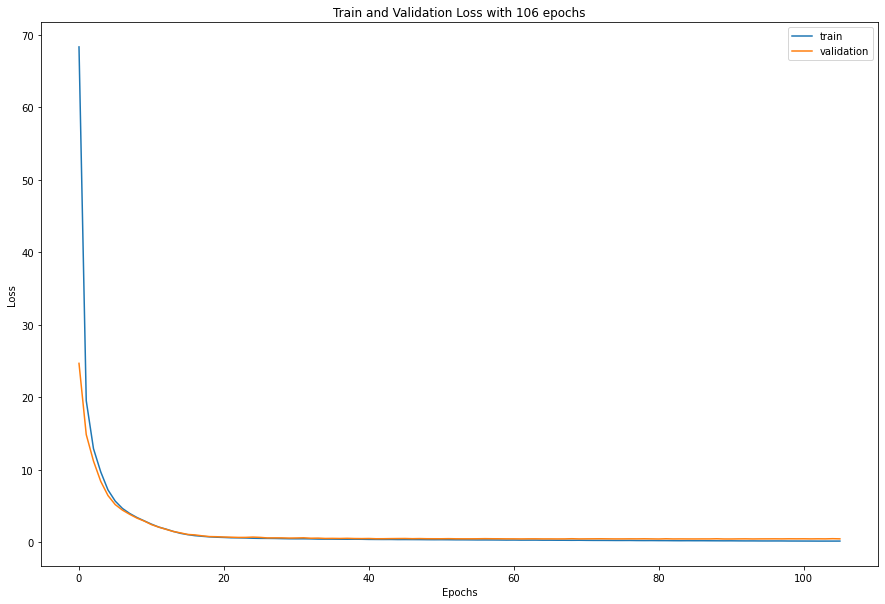

In [68]:
patience=25
# plot training and validation history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [69]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

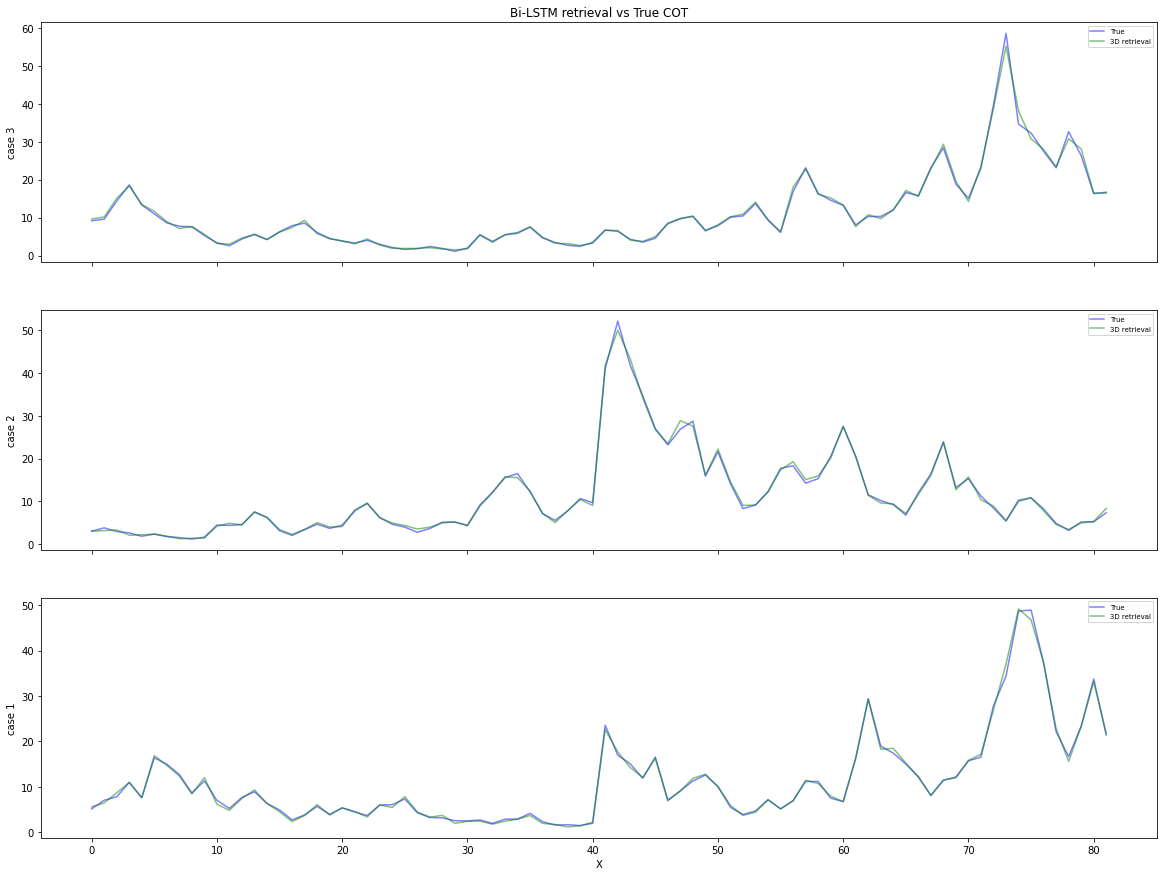

In [34]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds_Bi-LSTM SZA=60 VZA=0 "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM retrieval vs True COT")
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D retrieval"],fontsize='x-small')
ax.set_ylabel(r"case 3") 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize='x-small')
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize='x-small')
ax.set_ylabel(r"case 1")  
ax.set_xlabel('X')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values

In [46]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)

In [43]:
len(mean)

82

In [45]:
len(std)

82

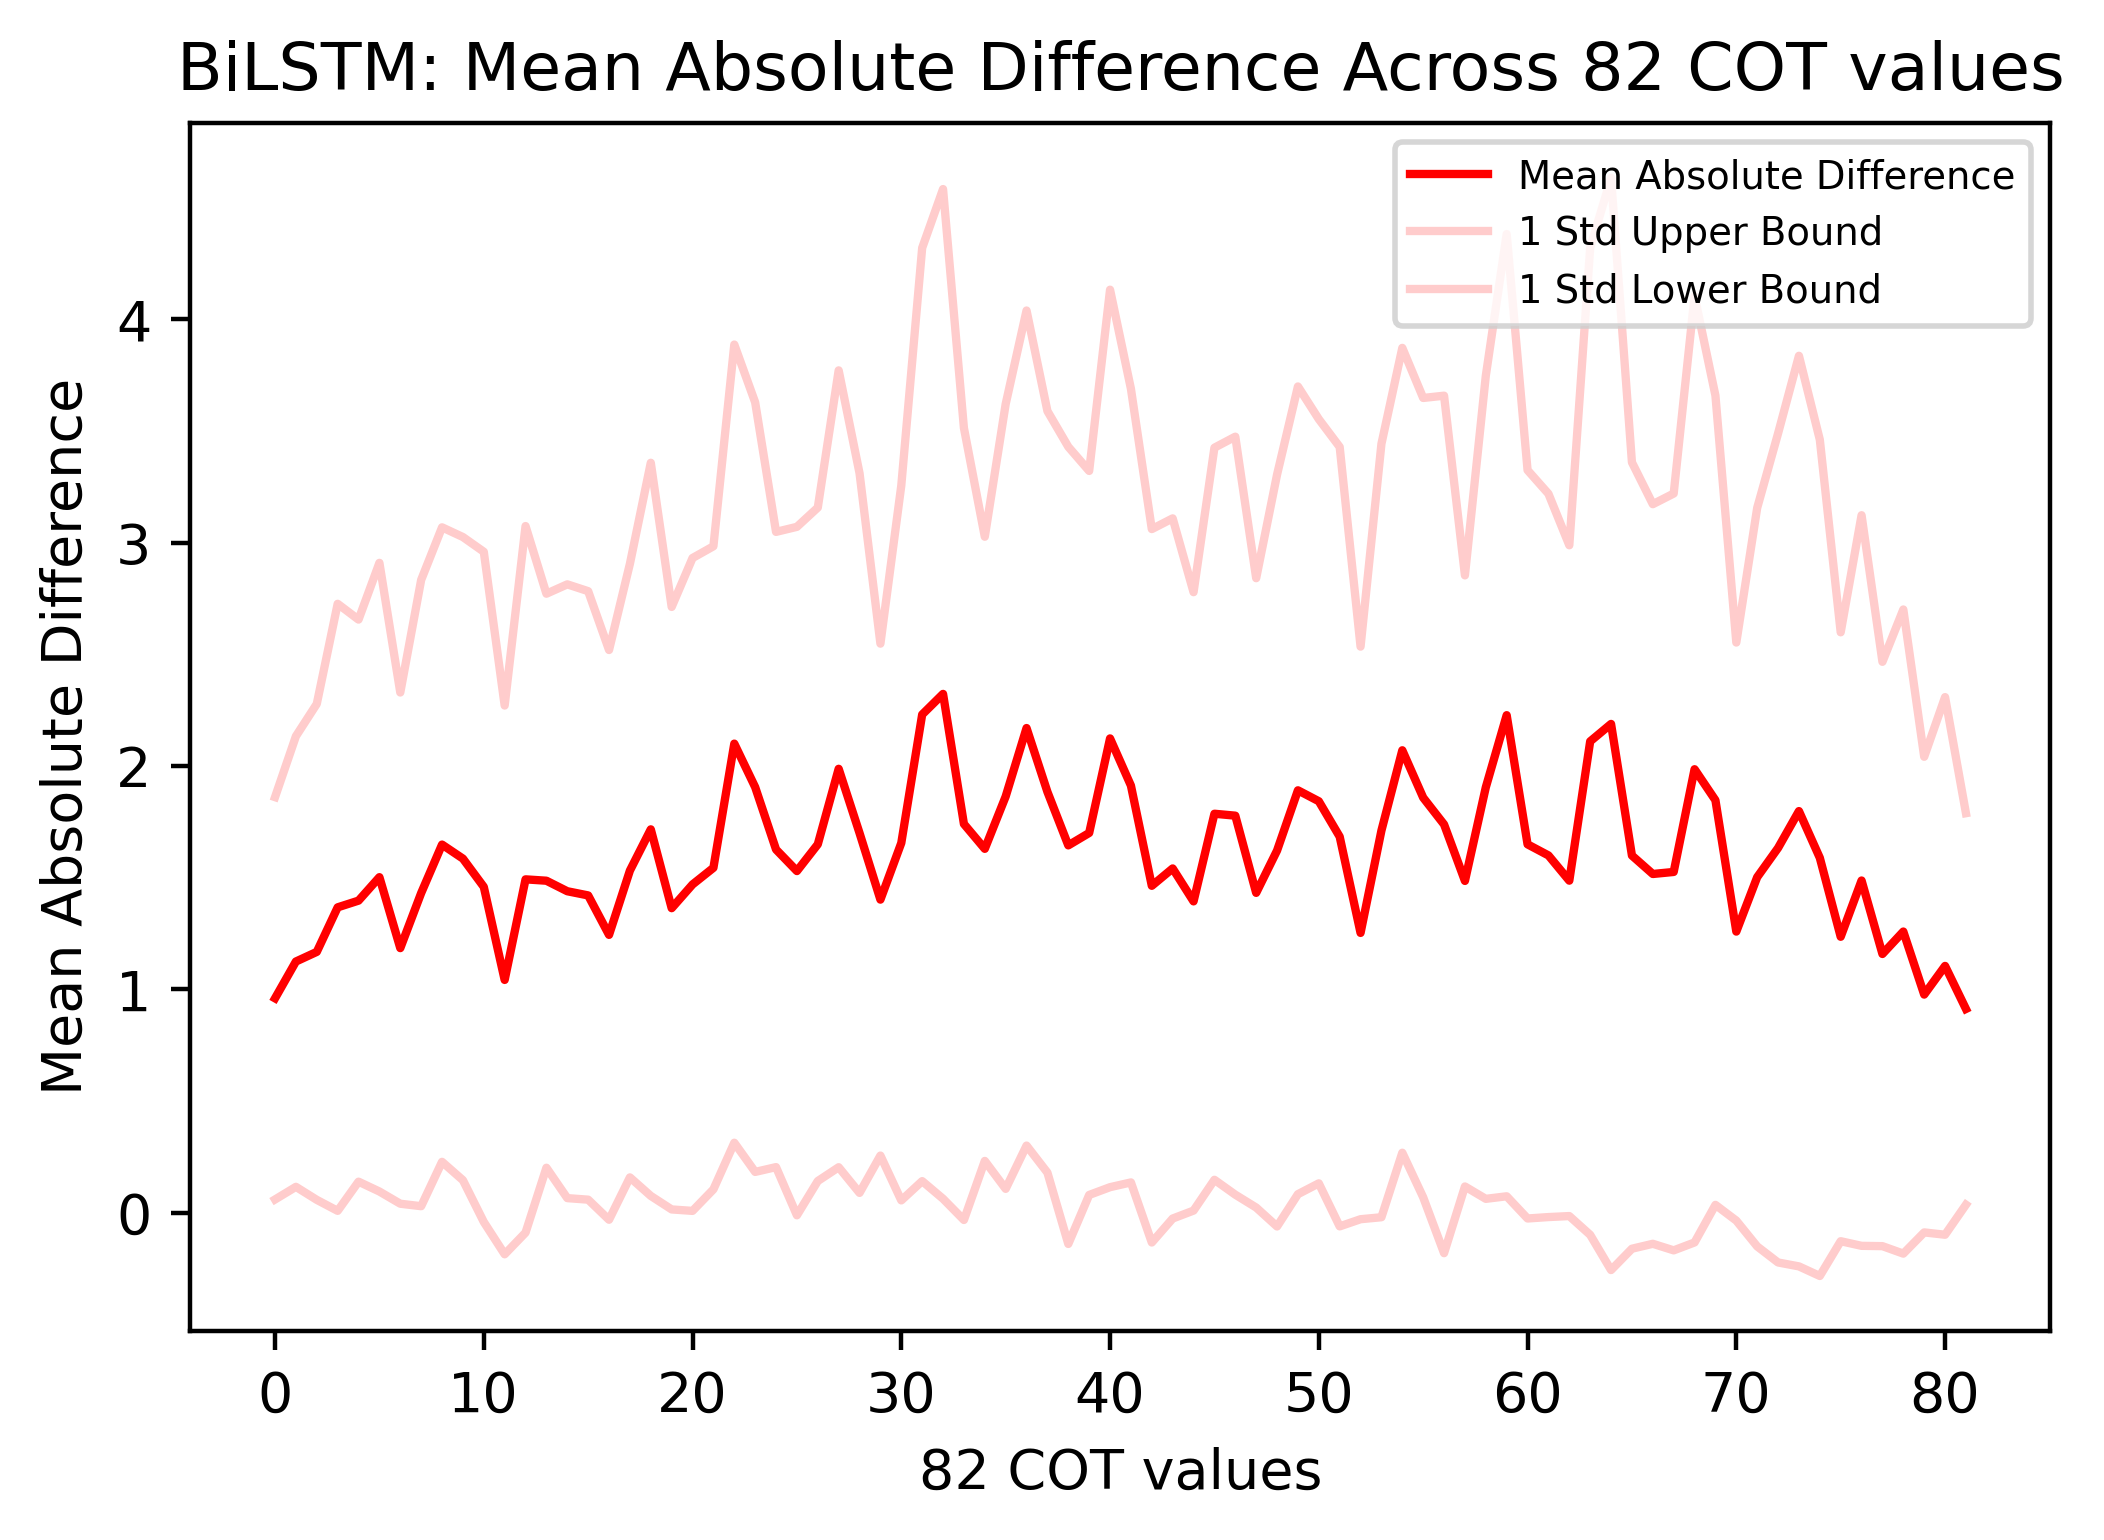

In [48]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/v1-BiLSTM_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

# Physics Method 

# Test set comparison: mse and rmse 

In [103]:
#after shuffle, the last 800 profiles in cot_data are test set
test_lb= cot_data[3200:4000]
test_lb.shape

(800, 4096)

In [107]:
#find which profiles are in test_lb

corresponding_1d=[]
for i in range(800):
    for j in range(4000):
        fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(j+1)
        hf = h5py.File(fname, 'r')
        cot=np.array(hf.get('tau')) #ground truth
        equal=np.array_equal(test_lb[i],cot) #find which profiles are in test_lb
        if equal is True:
            print(fname)
            corresponding_1d.append(fname)

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00116.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00289.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03770.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03335.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01182.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00338.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03482.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02688.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03061.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00047.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00748.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03668.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03208.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_007

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01706.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02882.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03293.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00595.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02988.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01334.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02215.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03878.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01552.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03350.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03318.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01543.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03407.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_003

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02404.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00293.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00699.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01049.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03701.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03201.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02418.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03870.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03905.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01668.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01964.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01250.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02275.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_012

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00787.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00874.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00740.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02868.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03292.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03506.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01007.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01845.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00587.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01307.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02990.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00349.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02472.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_010

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03420.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01401.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03915.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01393.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02258.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02178.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02238.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00137.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01471.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03153.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01279.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01974.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00895.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_001

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01914.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00957.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01489.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00026.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01135.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02198.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00926.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03225.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01553.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02745.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00844.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01646.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02938.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_035

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02768.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02840.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03003.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03300.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01685.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01168.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02025.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01205.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02917.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00973.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01156.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02037.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03947.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_010

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02608.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02733.hdf5


In [118]:
len(corresponding_1d)

800

In [114]:
#test if there are duplicate profiles 
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    print(len(unique_list))

In [115]:
#all the profiles are unique in corresponding 1d retrieval
unique(corresponding_1d)

800


In [122]:
one_d_retrieval=np.empty((800,4096), dtype=float)

for i in range(800):
    fname=corresponding_1d[i]
    hf = h5py.File(fname, 'r')
    a=np.array(hf.get('Retrieved_tau'))#1D retrieval
    one_d_retrieval[i]=a

In [124]:
#MSE RMSE for 1D retreival by test set (800 profiles)

from sklearn.metrics import mean_squared_error
import math
# Calculation of Mean Squared Error (MSE)
#mse=mean_squared_error(Y_true,Y_pred)

mse=mean_squared_error(test_lb,one_d_retrieval)
rmse = math.sqrt(mse)

print('1D retrieval MSE:',mse)
print('1D retrieval RMSE:',rmse)

1D retrieval MSE: 130.5281209194181
1D retrieval RMSE: 11.424890411702778


# Entire dataset comparison

In [10]:
#COT dataset
cot_data1=np.empty((4000,4096),dtype=float)
for i in range(0,4000):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\profiles/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    cot=np.array(hf.get('tau'))
    cot_data1[i]=cot
    hf.close()

In [11]:
one_d_retrieval_entire=np.empty((4000,4096), dtype=float)
for i in range(0,4000):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    a=np.array(hf.get('Retrieved_tau'))
    one_d_retrieval_entire[i]=a
    hf.close()

In [14]:
#MSE RMSE for 1D retreival for entire COT dataset and corresponding 1D retrieval (4000 profiles)
from sklearn.metrics import mean_squared_error
import math
mse=mean_squared_error(cot_data1,one_d_retrieval_entire)
rmse = math.sqrt(mse)

In [15]:
print('1D retrieval MSE:',mse)
print('1D retrieval RMSE:',rmse)

1D retrieval MSE: 126.59652562760502
1D retrieval RMSE: 11.25151214848942


# Finding out which profiles are the last three profiles in testset

In [26]:
for i in range(0,num):#4000
    fname = c[i]
    #hf = h5py.File(fname, 'r')
   # cot = np.array(hf.get("tau"))
    equal=np.array_equal(fname,c[num-3]) #3rd last profile
    if equal is True:
        print(i)
        print(fname)

3997
[ 9.19440786  9.59398037 14.35442831 18.64310505 13.32939178 11.00313015
  8.61502076  7.74891274  7.56773302  5.2716958   3.37034791  2.58012404
  4.35974952  5.64018178  4.20961618  6.26649606  7.89280609  8.55528198
  6.1017566   4.52975518  3.78536456  3.31148658  4.02461109  2.97183399
  2.12723636  1.62672217  1.80867788  2.4006211   1.88991543  1.12418498
  1.99481746  5.51593328  3.74048033  5.44516433  5.8769492   7.4876137
  4.65934373  3.46729558  2.71697314  2.43391475  3.49909391  6.71141674
  6.40677719  4.30480721  3.5567763   4.56976393  8.55637681  9.67886097
 10.41294371  6.64986363  7.86499398 10.11460697 10.44813858 13.67914747
  9.3650009   6.11384225 16.82215311 23.13865887 16.4082855  14.56776581
 13.27341182  8.09387665 10.31288206 10.30505748 12.04492646 16.59946003
 15.80946771 23.13986964 28.36561845 18.83213141 15.10670088 23.06001967
 39.72561261 58.57947461 34.63429517 32.30097065 27.49721521 23.12313677
 32.64443278 26.35709699 16.32918813 16.6943697

In [28]:

physics_retrieval03997 = c[3997]
physics_retrieval03997

array([ 9.19440786,  9.59398037, 14.35442831, 18.64310505, 13.32939178,
       11.00313015,  8.61502076,  7.74891274,  7.56773302,  5.2716958 ,
        3.37034791,  2.58012404,  4.35974952,  5.64018178,  4.20961618,
        6.26649606,  7.89280609,  8.55528198,  6.1017566 ,  4.52975518,
        3.78536456,  3.31148658,  4.02461109,  2.97183399,  2.12723636,
        1.62672217,  1.80867788,  2.4006211 ,  1.88991543,  1.12418498,
        1.99481746,  5.51593328,  3.74048033,  5.44516433,  5.8769492 ,
        7.4876137 ,  4.65934373,  3.46729558,  2.71697314,  2.43391475,
        3.49909391,  6.71141674,  6.40677719,  4.30480721,  3.5567763 ,
        4.56976393,  8.55637681,  9.67886097, 10.41294371,  6.64986363,
        7.86499398, 10.11460697, 10.44813858, 13.67914747,  9.3650009 ,
        6.11384225, 16.82215311, 23.13865887, 16.4082855 , 14.56776581,
       13.27341182,  8.09387665, 10.31288206, 10.30505748, 12.04492646,
       16.59946003, 15.80946771, 23.13986964, 28.36561845, 18.83